# Training ANNs

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-nc-sa/4.0/80x15.png" /></a>&nbsp;| Dennis G. Wilson | <a href="https://d9w.github.io/deep-learning-intro/">https://d9w.github.io/deep-learning-intro/</a><br>Based on the Supaero Data Science Deep Learning class: https://supaerodatascience.github.io/deep-learning/

Let's define a neural network that has the following structure:
- 2 input neurons
- first hidden layer with 4 sigmoid neurons
- second hidden layer with 3 sigmoid neurons
- one ouput layer with an identity neuron

<img src="img/nn2.png" width="600px"></img>

Let's initialize its weights randomly (following a $\mathcal{N}(0,1)$ distribution).

In [4]:
import numpy as np
sizes = [2,4,3,1]
num_layers = len(sizes)
biases = [np.random.randn(1,y) for y in sizes[1:]]
weights = [np.random.randn(out,inp) for inp,out in zip(sizes[:-1],sizes[1:])]

def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

<div class="alert alert-warning">
    
**Exercice:**<br>
Write a function that computes the forward propagation of the input $x=[1,2]$ through the network and returns the outputs and all intermediate activations.
</div>

In [5]:
# %load solutions/code1.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

# Learning the weights of a neural network

Suppose that the value associated to $x=[1,2]$ in the previous example was $12.3$. That is not what was predicted and we could wish to adapt the weights of the network so that the next time we propagate $x=[1,2]$ through the network, the prediction is closer to $12.3$.

Let's do a bit of math to formalize the search for the best neural network for our data.

Let's first suppose that our data points $(x,y)$ are drawn from a probability distribution $p(x,y)$.

## 5.1 Loss function

After all, a neural network with a fixed graph structure is a parametric function $f_\theta$ where $\theta$ is the vector of all parameters (all weights and biases). Learning a neural network that correctly predicts $y$ corresponds to finding the parameters $\theta$ that minimize the following function.
$$L(\theta) = \displaystyle \mathbb{E}_{(x,y)\sim p(x,y)} \left[ \left(f_\theta(x) - y\right)^2 \right] = \int_{x,y} \left[ \left(f_\theta(x) - y\right)^2 \right] \mathrm{d}p(x,y) $$

This is what we shall call the *loss function*. The smaller $L(\theta)$, the happier we are.

Note that we have defined $L(\theta)$ as a least squares minimization problem and that other loss functions could be relevant for certain problems.

<div class="alert alert-warning">
    
**Exercice:**<br>
Using the training data provided below, estimate the loss function for the current parameters $\theta$ of the network defined in the previous section.
</div>

In [6]:
input_X = np.array([[1.,2.],[1.1,1.7],[0.8,1.9]])
def func(x):
    return np.sqrt(x[:,0]+x[:,1])
output_y = func(input_X)

In [7]:
# %load solutions/code2.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).


## 5.2 Stochastic gradient descent

Let's say we have an initial guess $\theta_0$ for the parameters of $f_\theta$. How can we change this guess so that we minimize $L(\theta)$? Plain gradient descent tells us we should move in the opposite direction of the gradient of $L(\theta)$ with respect to $\theta$. So let's write this gradient:

\begin{align*}
\displaystyle \nabla_\theta L(\theta) &= \nabla_\theta \left[ \mathbb{E}_{(x,y)\sim p(x,y)} \left[ \left(f_\theta(x) - y\right)^2 \right] \right]\\
&= \mathbb{E}_{(x,y)\sim p(x,y)} \left[ \nabla_\theta \left[ \left(f_\theta(x) - y\right)^2 \right] \right]\\
&= \mathbb{E}_{(x,y)\sim p(x,y)} \left[ 2 \left(f_\theta(x) - y\right) \nabla_\theta f_\theta(x) \right]
\end{align*}

So, the gradient of $L(\theta)$ is the expectation of $2 \left(f_\theta(x) - y\right) \nabla_\theta f_\theta(x)$. In other words:

$$\nabla_\theta L(\theta) = \int_{x,y} 2 \left(f_\theta(x) - y\right) \nabla_\theta f_\theta(x) \mathrm{d}p(x,y)$$

The problem with this expression is that it requires the knowledge of $p(x,y)$ for all possible $(x,y)$ pairs. That would mean having an infinite amount of data. We can, however, try to approximate this gradient with a finite data set $\left\{\left(x_i,y_i\right)\right\}_{i\in [1,N]}$:
$$\nabla_\theta L(\theta) \approx \sum_{i=1}^N 2 \left(f_\theta(x_i) - y_i\right) \nabla_\theta f_\theta(x_i)$$

This is actually a *noisy estimation of the gradient* (that converges to the true gradient in the limit of infinite sampling). The theory of *stochastic gradient descent* tells us that if $g(\theta)$ is a noisy estimator of $\nabla_\theta L(\theta)$, then the following sequence $\theta_k$ converges to a local minimum of $L(\theta)$:
$$\theta_{k+1} = \theta_k - \alpha_k g(\theta_k)$$
under the condition that $\sum \alpha_k = \infty$ and $\sum \alpha_k^2 < \infty$ (called the Robbins-Monro conditions).

**A Stochastic Approximation Method**.
H. Robbins and S. Monro (1951). *The Annals of Mathematical Statistics*. **22**(3): 400. 

The first condition $\sum \alpha_k = \infty$ insures that whatever the starting parameters $\theta_0$, no matter how far from $\theta_0$ the minimum is, this procedure can reach it.

The second condition $\sum \alpha_k^2 < \infty$ forces the step sizes to be a decreasing sequence and avoids oscillations around the minimum.

Here we have
$$g(\theta) = \sum_{i=1}^N 2 \left(f_\theta(x_i) - y_i\right) \nabla_\theta f_\theta(x_i).$$

To simplify the notation we shall write $\alpha$ instead of $\alpha_k$.

One complete pass (to compute the $\sum_{i=1}^N$) over the training set will be called a *training epoch*.

## 5.3 Minibatches

Notation disambiguation: $\theta_k$ refers to the $k$th parameter vector in the sequence above, $\theta_j$ refers to the $j$th component of vector $\theta$.

Now we have a procedure that allows to find some optimal weights for our network. Provided that, for all parameter $\theta_j$ in the parameter vector $\theta$, we can compute $\frac{\partial f_\theta}{\partial \theta_j}(x)$, then we can calculate:
$$g_{j}(\theta) = \sum_{i=1}^N 2 \left(f_{\theta}(x_i) - y_i\right) \frac{\partial f_{\theta}}{\partial\theta_j}(x_i)$$
And thus we can update $\theta_j$ with:
$$\theta_j \leftarrow \theta_j - \alpha g_{j}(\theta)$$

So the computation of all the components in $g(\theta)$ and the update of each element in $\theta$ can be done in *parallel*.

It appears, however, that for large datasets, summing over the $N$ elements is computationally expensive. So we could define a cheaper (but noiser) version of the gradient by summing only over a random subset of $n$ training points ($n \ll N$): 
$$\nabla_\theta L(\theta) \approx g(\theta) = \sum_{i=1}^n 2 \left(f_\theta(x_i) - y_i\right) \nabla_\theta f_\theta(x_i) $$

Such a subset is called a *minibatch*. When $n=1$, the gradient estimate is based on a single example and is thus very (very!) noisy and convergence can be very slow and unstable. When $n\rightarrow N$ the noise level decreases at the expense of a heavier computational cost. In practice, the noise level decreases quickly enough that we can take $n\in [50;1000]$ in most cases.

## 5.4 Recursive gradient computation

For the update above to be feasible, we need to have a differentiable $f_\theta$. Let's take a close look at the gradient $\nabla_\theta f_\theta(x)$ and write it as:
\begin{align*}
\nabla_\theta f_\theta(x) &= \left[ \begin{array}{c} \vdots \\ \frac{\partial f_\theta}{\partial\theta_j}(x) \\ \vdots \end{array}\right]
\end{align*}

In the case of a neural network, the $\theta_j$ are weights and biases. Let's consider neuron number $j$ and let's write $w_{ij}$ its input weights (with the convention that $i=0$ corresponds to the bias). We will write:
- $x_{ij}$ the $i$th input to this neuron
- $y_j = \sum_i w_{ij} x_{ij}$ the scalar input to the activation function
- $z_j = \sigma (y_j)$ the neuron's output
<img src="attachment:neuronj-0.png" width="300px"></img>

These three quantities have been computed during the *forward pass*, when $x$ was propagated through the network to obtain $f_\theta(x)$.

<div class="alert alert-warning">
    
**Exercice:**<br>
Use the chain rule to write $\frac{\partial f_\theta}{\partial w_{ij}}(x)$ as an expression of the partial derivatives of $f_\theta$ with respect to $z_j$ and $y_j$. Simplify this expression.
</div>

Using the chain rule, we can write:
$$\frac{\partial f_\theta}{\partial w_{ij}}(x) = \frac{\partial f_\theta}{\partial z_j}(x) \frac{\partial z_j}{\partial y_j}(x) \frac{\partial y_j}{\partial w_{ij}}(x).$$

Let's decompose this expression. First we take the last (third) term. We have $y_j = \sum_i w_{ij} x_{ij}$, so:
$$\frac{\partial y_j}{\partial w_{ij}}(x) = x_{ij}.$$

Then we take the second term. We have $z_j = \sigma(y_j)$, so:
$$\frac{\partial z_j}{\partial y_j}(x) = \sigma'(y_j).$$

And so:
$$\boxed{\frac{\partial f_\theta}{\partial w_{ij}}(x) = \frac{\partial f_\theta}{\partial z_j}(x) \sigma'(y_j) x_{ij}}.$$

Only the first term remains to be calculated in the expression above.
<div class="alert alert-warning">
    
**Exercice:**<br>
Suppose that $j$ is an output neuron. What is $\frac{\partial f_\theta}{\partial z_j}(x)$? And consequently, what is the value of $\frac{\partial f_\theta}{\partial w_{ij}}(x)$?
</div>

Let's assume $j$ is an output neuron. In this case, $z_j$ is the $j$th component of $f_\theta(x)$, and we have:
$$\frac{\partial f_\theta}{\partial z_j}(x) = 1.$$

Consequently, for the neurons of the output layer:
$$\boxed{\frac{\partial f_\theta}{\partial w_{ij}}(x) = \sigma'(y_j) x_{ij}}.$$

And hence, the update of the input weights $w_{ij}$ for output neuron $j$ (in the output layer) is:
$$w_{ij} \leftarrow w_{ij} - \alpha \left(f_\theta(x) - y\right)\sigma'(y_j) x_{ij}$$
Note that, in the expression above, $y$ is the value associated to $x$ (not to be confused with pre-neuron value $y_j$).

Now let's look at the neurons of the layer just preceding the output layer. Let's call $L_j$ the set of indices of the neurons that directly feed on neuron $j$'s output. $z_j$ corresponds to the $x_{jl}$ variable for these neurons and $y_l$ is the scalar input to neuron $l$. 

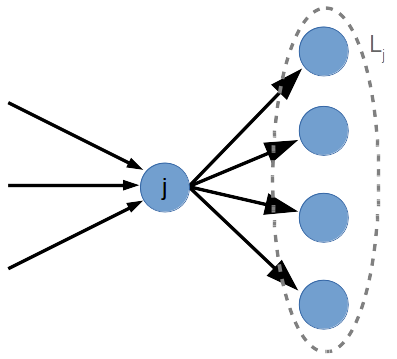</img>

<div class="alert alert-warning">
    
**Exercice:**<br>
Remark that $x_{jl}=z_j$. Take the total derivative of $f_\theta$ and derive a recurrence relation between $\frac{\partial f_\theta}{\partial z_j}(x)$ and the $\frac{\partial f_\theta}{\partial z_l}(x)$.
</div>

We can take the total derivative:
$$\frac{\partial f_\theta}{\partial z_j}(x) = \sum_{l \in L_j} \frac{\partial f_\theta}{\partial y_l}(x) \frac{\partial y_l}{\partial z_j}(x).$$

And so, we can write:
$$\frac{\partial f_\theta}{\partial z_j}(x) = \sum_{l \in L_j} \frac{\partial f_\theta}{\partial z_l}(x) \frac{\partial z_l}{\partial y_l}(x) \frac{\partial y_l}{\partial z_j}(x).$$

As previously:
$$\frac{\partial z_l}{\partial y_l}(x) = \sigma'(y_l)\textrm{ and }\frac{\partial y_l}{\partial z_j}(x) = w_{jl}$$

So this total derivative turns into:
$$\boxed{\frac{\partial f_\theta}{\partial z_j}(x) = \sum_{l \in L_j} \frac{\partial f_\theta}{\partial z_l}(x) \sigma'(y_l) w_{jl}}.$$

This provides a recurrence relation between $\displaystyle \frac{\partial f_\theta}{\partial z_j}(x)$ and $\displaystyle \frac{\partial f_\theta}{\partial z_l}(x)$ for $l \in L_j$.

Let's write $\boxed{\displaystyle  \delta_j = \frac{\partial f_\theta}{\partial z_j}(x) \sigma'(y_j)}$. Recall that our goal is to evaluate:
$$\frac{\partial f_\theta}{\partial w_{ij}}(x) = \frac{\partial f_\theta}{\partial z_j}(x) \frac{\partial z_j}{\partial y_j}(x) \frac{\partial y_j}{\partial w_{ij}}(x) = \frac{\partial f_\theta}{\partial z_j}(x) \sigma'(y_j) x_{ij} = \delta_j x_{ij},$$
$$\boxed{\frac{\partial f_\theta}{\partial w_{ij}}(x) = \delta_j x_{ij}}.$$

And we have the following recurrence equation between neuron $j$ and its siblings in $L_j$:
$$\delta_j = \sigma'(y_j)\sum_{l\in L_j} \delta_l w_{jl}$$

And, in particular, for output neurons:
$$\delta_j = \frac{\partial f_\theta}{\partial z_j}(x) \sigma'(y_j) = \sigma'(y_j)$$

In short:
$$\boxed{\delta_j = \left\{\begin{array}{ll}
\sigma'(y_j) & \textrm{for output neurons,}\\
\sigma'(y_j)\sum_{l\in L_j} \delta_l w_{jl} & \textrm{for other neurons.}
\end{array}\right.}$$

## 5.5 Backpropagation

Let's summarize. The key to backpropagation is to remark that in all cases:
$$\frac{\partial f_\theta}{\partial w_{ij}}(x) = \delta_j x_{ij}.$$

With 
$$\delta_j = \frac{\partial f_\theta}{\partial z_j}(x) \sigma'(y_j).$$

If neuron $j$ is an output neuron, then $z_j$ is the $j$th component of $f_\theta(x)$. So $ \frac{\partial f_\theta}{\partial z_j}(x) = 1$. Consequently, for those neurons:
$$\delta_j = \frac{\partial f_\theta}{\partial z_j}(x) \sigma'(y_j) = \sigma'(y_j).$$

Recursively, once all the $\delta_j$ for the output layer have been computed, we can compute the $\delta_j$ for the last hidden layer as:
$$\delta_j = \sigma'(y_j) \sum_{l\in L_j} \delta_l w_{jl}.$$

And the input weights of neuron $j$ can be updated as:
$$w_{ij} \leftarrow w_{ij} - \alpha \left(f_\theta(x) - y\right) \delta_j x_{ij}.$$

Once, all these weights have been updated and all the $\delta_j$ have been computed for the corresponding neurons, we can move one layer back in the network, and so on until we reach the input layer.

This algorithm is called *Backpropagation* of the gradient.

<div class="alert alert-success">
The backpropagation algorithm allows to update the networks weights.<br>

**Forward pass:**
<ol style="list-style-type:none">
<li> Input $x$
<li> $\lambda=$input layer
<li> While $\lambda\neq$ output layer:
    <ol style="list-style-type:none">
    <li>For $j$ in $\lambda$:
        <ol  style="list-style-type:none"><li>Compute $y_j=\sum w_{ij} x_{ij}$ and $z_j=\sigma(y_j)$</ol>
    <li> $\lambda \leftarrow$ next layer
    <li> $x \leftarrow z$
    </ol>
<li> Output $f_\theta(x)$
</ol>

**Backpropagation:**
<ol style="list-style-type:none">
<li> Output difference $\Delta = f_\theta(x) - y$
<li> For $j$ in output layer $\delta_j = \sigma'(y_j)$
<li> $\lambda =$ output layer
<li> While layer $\lambda \neq$ input layer:
    <ol style="list-style-type:none">
    <li> For $j$ in $\lambda$:
        <ol style="list-style-type:none">
        <li>Compute $\delta_j = \sigma'(y_j) \sum_{l\in L} \delta_l w_{jl}$ (only if not output layer)
        <li>Update $w_{ij} \leftarrow w_{ij} - \alpha \Delta \delta_j x_{ij}$</ol>
    <li> $\lambda=$previous layer
    </ol>
</ol>
</div>

A number of things can be remarked to make this computation more streamlined and efficient.

1. $\sigma'(x)=\sigma(x)\left(1-\sigma(x)\right)$ so one can get $\sigma'$ for free during the forward pass and store it.
2. all operations of the backward pass can be written in matrix form (just as for the forward pass).
3. in the notations above, $x_{0j}=1$ since it is the term that will be multiplied by the bias.
4. for a given $j$, all $x_{ij}$ in the notations above are really the $z$ value of the layer before neuron $j$.

One can easily rewrite the forward pass and the backpropagation as matrix/vector operations.<br>
Let $\lambda$ be the layer number, starting at 0 for the input layer.<br>
Let $w_{\lambda-1}$ denote the $p\times q$ weight matrix before layer $\lambda$ where $p$ is the size of layer $\lambda$ and $q$ is the size of layer $\lambda-1$ (plus one for the biases).<br>
Finally, let $\circ$ denote the element-wise product (Hadamard product) of two matrices.

<div class="alert alert-success">

**Forward pass:**
<ol style="list-style-type:none">
<li> Input $x$
<li> $\lambda=1$
<li> While $\lambda\neq$ output layer index:
    <ol style="list-style-type:none">
    <li> Compute $y_\lambda = w_{\lambda-1}^T x$, 
    <li> Compute $z_\lambda = \sigma (y_\lambda)$ and $s_\lambda = \sigma'(y_\lambda)$
    <li> $\lambda \leftarrow \lambda+1$
    <li> $x \leftarrow z_\lambda$
    </ol>
<li> Output $f_\theta(x)$
</ol>

**Backpropagation:**
<ol style="list-style-type:none">
<li> Output difference $\Delta = f_\theta(x) - y$
<li> $\lambda=$ output layer index
<li> $\delta_\lambda = s_\lambda$
<li> $w_{\lambda-1} \leftarrow w_{\lambda-1} - \alpha \Delta (\delta_\lambda \cdot z_{\lambda-1}^T)$
<li> $\lambda\leftarrow \lambda -1$
<li> While $\lambda \neq 0$:
    <ol style="list-style-type:none">
    <li> $\delta_\lambda = s_\lambda \circ (\delta_{\lambda+1}\cdot w_\lambda)$
    <li> $w_{\lambda-1} \leftarrow w_{\lambda-1} - \alpha \Delta (\delta_\lambda \cdot z_{\lambda-1}^T)$
    <li> $\lambda\leftarrow \lambda -1$
    </ol>
</ol>
</div>

Note that backpropagation is a very general principle for propagating gradients in a computational graph. Any activation function can be substituted in the expressions above, and a very similar derivation can be obtained for other loss functions (more on this later).

# 5.6 Backpropagation in practice

<div class="alert alert-warning">
    
**Exercice (collective):**<br>
Write a backpropagation pass for the minibatch containing the triplet $(x=(1,2),y=12.3)$, $(x=(3,1),y=3.4)$ and $(x=(2,5),y=5.1)$ on the network defined before.
</div>

To help fix ideas, the picture below summarizes all the data structures used.
<img src="img/nn3.png" width="600px"></img>

- in red, the network's data: w[i] and b[i] store the weights and biases,
- in blue, what is computed during the forward pass, y[i] for $w^x$, s[i] for $\sigma'(x)$, z[i] for neuron activations,
- in green, what is computed during the backward pass, $\delta$[i] and the weights and biases updates.

In [8]:
def sigmoid(z):
    """The sigmoid function."""
    val = 1.0/(1.0+np.exp(-z))
    der = val*(1.-val)
    return val, der

def forward_pass(x, verbose=False):
    z = [np.zeros((x.shape[0], sz)) for sz in sizes]
    s = [np.zeros((x.shape[0], sz)) for sz in sizes]
    y = [np.zeros((x.shape[0], sz)) for sz in sizes]
    z[0] = x.copy()
    for i in range(1,len(sizes)):
        if verbose:
            print("# Forward propagation to layer", i)
        y[i] = np.dot(z[i-1],weights[i-1].T) + biases[i-1]
        if verbose:
            print("Neuron inputs:", y[i])
        if i==len(sizes)-1:
            s[i] = np.ones((x.shape[0],sizes[-1]))
            z[i] = y[i]
        else:
            v,d  = sigmoid(y[i])
            s[i] = d
            z[i] = v
        if verbose:
            print("Layer outputs:", z[i])
    return y,s,z

Let's consider a batch of two training samples: $\left(x=(1,2),y=12.3\right)$ and $\left(x=(3,1),y=3.4\right)$.

In [9]:
#input_value = np.array([[1,2]])
#output_value = np.array([[12.3]])
input_value = np.array([[1,2],[3,1],[2,5]])
output_value = np.array([[12.3],[3.4],[5.1]])
y,s,z = forward_pass(input_value, verbose=False)

In [10]:
print(*z, sep="\n")

[[1 2]
 [3 1]
 [2 5]]
[[0.39902024 0.32425398 0.78195906 0.13149247]
 [0.77817113 0.83474883 0.02473264 0.00654918]
 [0.51740279 0.09306017 0.98503869 0.0439967 ]]
[[0.07350711 0.45591053 0.23446648]
 [0.12222857 0.39710465 0.61412177]
 [0.09145643 0.52100235 0.22390318]]
[[0.32498199]
 [0.43161655]
 [0.36433761]]


In [11]:
def backward_pass(out, y, s, z, alpha):
    delta = [np.zeros((out.shape[0], sz)) for sz in sizes]
    error = z[len(sizes)-1] - out
    for i in range(len(sizes)-1,0,-1):
        # compute delta
        if i==len(sizes)-1:
            delta[i] = s[len(sizes)-1]
        else:
            delta[i] = np.dot(delta[i+1],weights[i])
            delta[i] = np.multiply(delta[i],s[i])
        # intermediate delta value that includes the error term 
        # (useful for minibatches since each element has a different error value)
        delta_temp = np.multiply(delta[i],error)
        # update weights
        grad_w = np.dot(delta_temp.T,z[i-1])
        grad_b = np.sum(delta_temp, axis=0)
        weights[i-1] -= alpha * grad_w
        biases[i-1]  -= alpha * grad_b
    return

In [12]:
backward_pass(output_value, y, s, z, 0.1)

Let's monitor the training error for various training sets and weight initialization.

In [13]:
#input_value = np.array([[1,2]])
#output_value = np.array([[12.3]])
#input_value = np.array([[1,2],[3,1]])
#output_value = np.array([[12.3],[3.4]])
input_value = np.array([[1,2],[3,1],[2,5]])
output_value = np.array([[12.3],[3.4],[5.1]])

sizes = [2,4,3,1]
biases = [np.random.randn(1,y) for y in sizes[1:]]
weights = [np.random.randn(out,inp) for inp,out in zip(sizes[:-1],sizes[1:])]

In [14]:
nsteps = 500
training_loss = np.zeros(nsteps)
for i in range(nsteps):
    y,s,z = forward_pass(input_value, verbose=False)
    training_loss[i] = np.mean((z[-1]-output_value)**2)
    backward_pass(output_value, y, s, z, 0.1)

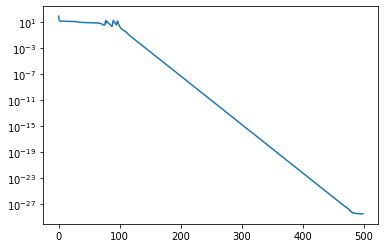

In [16]:
import matplotlib.pyplot as plt
plt.semilogy(training_loss);

In [17]:
y,s,z = forward_pass(input_value, verbose=False)
print(z[-1])
print(output_value)

[[12.3]
 [ 3.4]
 [ 5.1]]
[[12.3]
 [ 3.4]
 [ 5.1]]


Ok. It seems to work, we've learned a network that can memorize the three point-wise mappings:
$$\begin{array}{ccc} 
(1,2) & \rightarrow & 12.3\\
(3,1) & \rightarrow & 3.4 \\
(2,5) & \rightarrow & 5.1
\end{array}$$

That's a good start. Let's try to generalize this to any number of points. <br>
Let's re-initialize and check the learning on the noise-less function $x_0,x_1\mapsto \sqrt{x_0+x_1}$.<br>
This time we shall visualize both the training and testing error.

In [18]:
sizes = [2,4,3,1]
biases = [np.random.randn(1,y) for y in sizes[1:]]
weights = [np.random.randn(out,inp) for inp,out in zip(sizes[:-1],sizes[1:])]

In [19]:
# generate training and testing sets
def func(x):
    return np.sqrt(x[:,0]+x[:,1])

testing_x  = np.random.uniform(size=(100,2))
testing_y  = func(testing_x).reshape(-1,1)
training_x = np.random.uniform(size=(100,2))
training_y = func(training_x).reshape(-1,1)

# compute initial generalization loss
y,s,z = forward_pass(testing_x, verbose=False)
err = np.mean((z[-1]-testing_y)**2)
print("Generalization loss estimate:",err)

Generalization loss estimate: 3.2162261563274437


In [20]:
nsteps = 1000
training_loss = np.zeros(nsteps)
testing_loss  = np.zeros(nsteps)

for i in range(nsteps):
    _,_,z_test = forward_pass(testing_x, verbose=False)
    testing_loss[i]  = np.mean((z_test[-1]-testing_y)**2)
    y_train,s_train,z_train = forward_pass(training_x, verbose=False)
    training_loss[i] = np.mean((z_train[-1]-training_y)**2)
    backward_pass(training_y, y_train, s_train, z_train, 0.001)

last training loss: 0.026667999474073265
last generalization loss: 0.03268009432595112


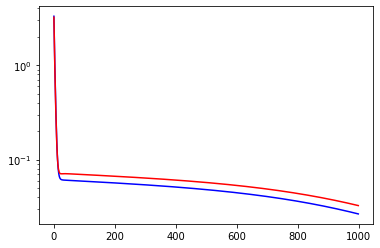

In [21]:
plt.semilogy(training_loss, c='b')
plt.semilogy(testing_loss, c='r')
print("last training loss:", training_loss[-1])
print("last generalization loss:", testing_loss[-1])

Let's try some random values.

In [22]:
x = np.random.uniform(size=(10,2))
ztrue = func(x).reshape(-1,1)
print(ztrue)
_,_,zpred = forward_pass(x)
print(zpred[-1])
print(ztrue-zpred[-1])

[[0.91384975]
 [1.01343907]
 [0.72713038]
 [0.99034753]
 [0.99558216]
 [1.14773077]
 [1.02484033]
 [0.9244507 ]
 [0.97459838]
 [0.84796007]]
[[0.9417127 ]
 [0.97995003]
 [0.84258444]
 [1.01980403]
 [0.88157029]
 [1.00450239]
 [0.89665393]
 [1.00589676]
 [0.98080959]
 [0.97167787]]
[[-0.02786295]
 [ 0.03348904]
 [-0.11545406]
 [-0.0294565 ]
 [ 0.11401187]
 [ 0.14322838]
 [ 0.1281864 ]
 [-0.08144606]
 [-0.0062112 ]
 [-0.1237178 ]]


**Obervations.**<br>
It's not so impressive. Sometimes the weight optimization even diverges. But (in theory) we (should) have found the best possible fit for the neural network's weights since what we did was (attempt to) minimize the loss function. So why is it so bad?

A few possible answers at this stage:
- The $x_0,x_1\mapsto \sqrt{x_0+x_1}$ function just cannot be satisfyingly represented with this neural network architecture.
- The stochastic gradient descent procedure got stuck in a local minimum of the loss function.
- When divergence occured, the (constant) learning rate was not small enough to keep the gradient steps small.

What's your opinion on these phenomena and their possible solutions?

**Note.**<br>
You can find this code wrapped-up as a Python class in `ann.py`

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import ann

In [55]:
sizes = [2,4,3,1]
myann = ann.ANN(sizes)

In [33]:
ids = np.append([0], np.cumsum(sizes))
id_layers = []
G = nx.Graph()
for l in range(1, len(ids)):
    id_layers.append([i for i in range(ids[l-1], ids[l])])
for l in range(len(id_layers)):
    for i in id_layers[l]:
        G.add_node(i, subset=l)
for l in range(1, len(id_layers)):
    for i in id_layers[l-1]:
        for j in id_layers[l]:
            G.add_edge(i, j)

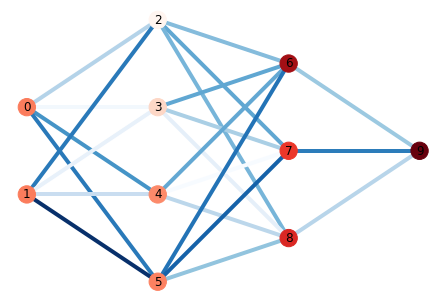

In [34]:
weights = [i for l in myann.weights for i in l.flatten()]
biases = np.concatenate((np.zeros(sizes[0]),
                         [i for l in myann.biases for i in l.flatten()]))
first_weights = np.copy(weights)
first_biases = np.copy(biases)
options = {
    "width": 4,
    "cmap": plt.cm.Reds,
    "edge_cmap": plt.cm.Blues,
    "with_labels": True,
}
pos = nx.multipartite_layout(G)            
nx.draw(G, pos, **options, edge_color=weights, node_color=biases)

In [58]:
import numpy as np
# generate training and testing sets
def func(x):
    return np.sqrt(x[:,0]+x[:,1])

testing_x  = np.random.uniform(size=(100,2))
testing_y  = func(testing_x).reshape(-1,1)
training_x = np.random.uniform(size=(100,2))
training_y = func(training_x).reshape(-1,1)

In [83]:
sizes = [2,4,3,1]
myann = ann.ANN(sizes)

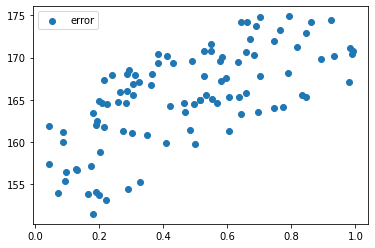

In [97]:
y, s, z = myann.forward_pass(training_x, verbose=False)
error = (z[-1] - training_y)**2
#plt.scatter(training_x[:, 0], training_y, label='target')
plt.scatter(training_x[:, 0], error, label='error')
plt.legend();

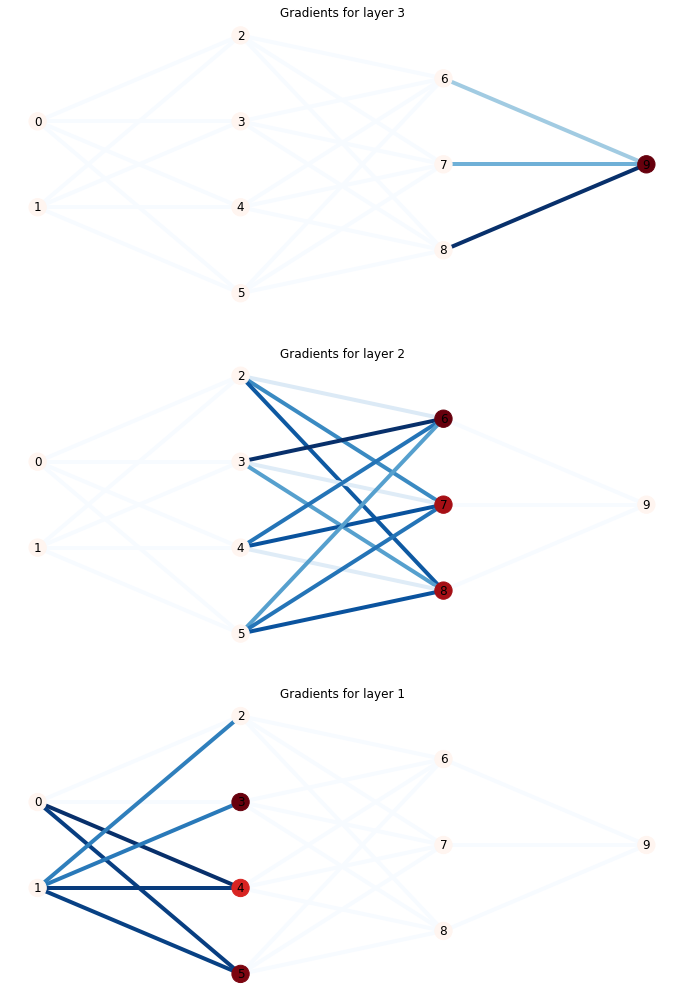

In [96]:
plt.figure(figsize=(12, 24))
# initialize gradient vectors for each layer
delta = [np.zeros((out.shape[0], sz)) for sz in myann.layer_sizes]
grad_w = [np.zeros((o, i)) for i, o in
      zip(myann.layer_sizes[:-1], myann.layer_sizes[1:])]
grad_b = [np.zeros((1, y)) for y in myann.layer_sizes[1:]]
#learning rate
alpha = 0.01
for i in range(len(myann.layer_sizes)-1, 0, -1):
    if i == len(myann.layer_sizes)-1:
        delta[i] = s[-1]
    else:
        delta[i] = np.dot(delta[i+1], myann.weights[i])
        delta[i] = np.multiply(delta[i], s[i])
    # delta at each layer
    delta_temp = np.multiply(delta[i], error)
    # reset weight gradients to 0 for plotting
    grad_w = [np.zeros((o, i)) for i, o in
          zip(myann.layer_sizes[:-1], myann.layer_sizes[1:])]
    # gradient of weights at this layer
    grad_w[i-1] = np.dot(delta_temp.T, z[i-1])
    # reset bias gradients to 0 for plotting
    grad_b = [np.zeros((1, y)) for y in myann.layer_sizes[1:]]
    # gradients of biases at this layer
    grad_b[i-1] = np.sum(delta_temp, axis=0)
    # flatten weight and bias gradients for plotting
    dw_flat = [np.abs(i) for l in grad_w for i in l.flatten()]
    db_flat = np.concatenate((np.zeros(sizes[0]),
                              [np.abs(i) for l in grad_b for i in l.flatten()]))
    # plot
    plt.subplot(len(myann.layer_sizes), 1, len(myann.layer_sizes)-i)
    plt.title("Gradients for layer "+str(i))
    nx.draw(G, pos, **options, edge_color=dw_flat, node_color=db_flat)
    # IMPORTANT: update weights for next step of backprop
    myann.weights[i-1] -= alpha * grad_w[i-1]
    myann.biases[i-1] -= alpha * grad_b[i-1]

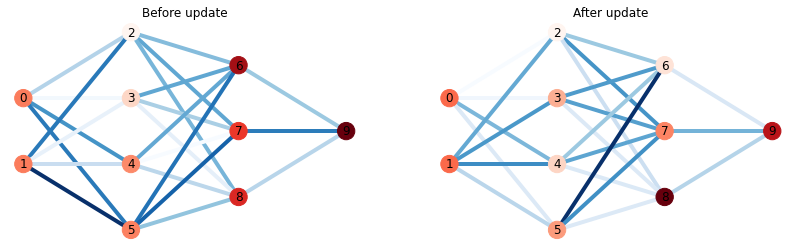

In [90]:
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.title("Before update")
nx.draw(G, pos, **options, edge_color=first_weights, node_color=first_biases)
weights = [i for l in myann.weights for i in l.flatten()]
biases = np.concatenate((np.zeros(sizes[0]),
                         [i for l in myann.biases for i in l.flatten()]))
plt.subplot(1, 2, 2)
plt.title("After update")
nx.draw(G, pos, **options, edge_color=weights, node_color=biases)

# 5.7 MLP in scikit-learn

Let's train our first neural network with scikit-learn.

nb points: 1000


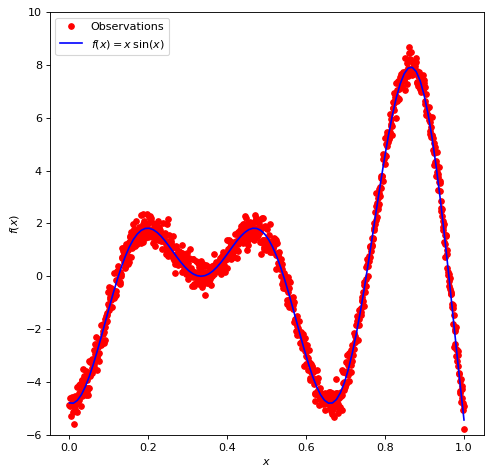

In [23]:
def func(x):
    x = 15.*x-5.
    return x*np.sin(x)

sigma_noise = 0.3
def observation(x):
    return func(x) + np.random.normal(0,sigma_noise,x.shape[0])

X = np.linspace(0,1,1000)
N = X.shape[0]
Y = observation(X)
x = np.linspace(0,1,100)

fig=plt.figure(figsize=(7,7), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(X, Y, 'r.', markersize=10, label=u'Observations')
plt.plot(x, func(x), 'b', label=u'$f(x) = x\,\sin(x)$')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-6, 10)
plt.legend(loc='upper left');

print("nb points:", N)

X=X.reshape(-1,1)

In [24]:
from sklearn.neural_network import MLPRegressor

myNN = MLPRegressor(hidden_layer_sizes=(100,10), activation='tanh', solver='lbfgs', max_iter=5000, learning_rate_init=0.1) 

In [25]:
myNN.fit(X,Y)

MLPRegressor(activation='tanh', hidden_layer_sizes=(100, 10),
             learning_rate_init=0.1, max_iter=5000, solver='lbfgs')

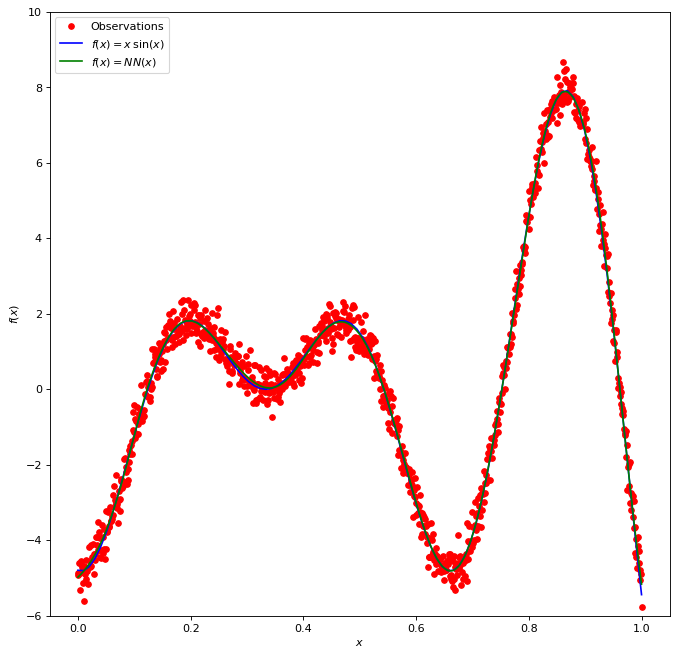

In [26]:
ypredict = myNN.predict(X)

fig=plt.figure(figsize=(10,10), dpi=80, facecolor='w', edgecolor='k')
plt.plot(X.ravel(), Y.ravel(), 'r.', markersize=10, label=u'Observations')
plt.plot(x, func(x), 'b', label=u'$f(x) = x\,\sin(x)$')
plt.plot(X, ypredict, 'g', label=u'$f(x) = NN(x)$')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-6, 10)
plt.legend(loc='upper left');